<a href="https://colab.research.google.com/github/sausis20/Youtube-Trending-Scraper-and-EDA/blob/main/feature_selection_and_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data and Libraries

In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [178]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 26, 6

In [2]:
cd '/content/gdrive/My Drive/Colab Notebooks/Nasdaq OMX Baltic/data/'

/content/gdrive/My Drive/Colab Notebooks/Nasdaq OMX Baltic/data


In [3]:
df = pd.read_csv('combined_df.csv', index_col=0)

# Feature Selection and Modeling

This section will be split into two major modeling tasks: asset price modeling and modeling of returns. For each, we will perform feature engineering, then compare the efficacy of imputation techniques, train machine learning algorithms, and then interpret the modeling results.

## Modeling Asset Price

The purpose of this task is to model the prices of the securities using the fundamental data found in the financial statements of the companies, and then to perform an analysis of intrinsic value to develop a value investing-style trading strategy based on the residuals of our model, which represent margin of safety, or in other words, how over or under valued a given security is compared to what the model estimates its value to be. The hypothesis is that the residuals will be correlated to the returns of the securities over the six month period since the data were scraped, as overvalued stocks would see their prices move down as the market adjusts toward their true value, and undervalued stocks would move up.

In financial analysis, intrinsic value is at least partially subjective, as different analysts will arrive at different estimates through construction of their own individual proprietary pricing models, meaning that in this experiment we are actually trying to model a hidden variable using the current trading price. The logic behind why this may work is that markets are at least partially efficient, meaning that the current prices of assets reliably reflect their value, with some error and noise present. So, while we are using market price as a target variable, the hope is that the model we build finds the way that the features contribute to prices across the market, and that our residuals will reflect deviations from actual (intrinsic) value.

In this study, two forms of target variable will be considered: one being the price of securities on the date when the fundamental data was published, and the other being the returns since then. The features that we need to choose for each task are different. For asset pricing model development (the first task of modeling current price), any features which contain information about the asset price should be left out, as this is a form of target leakage. For example, we should not use P/E ratio (Price divided by Earnings) as our explanatory variable if we are trying to predict Price, as this would make the model overfit the training data, but would perform poorly on new data. The main task of fundamental analysis is to estimate the intrinsic value of a security using fundamental information about the company in order to compare it to the current market price. If the current market price were to leak into the model, this would be detrimental to estimating the intrinsic value.

### Feature Selection
The dataset contains a lot of information. Before proceeding, we should eliminate some variables:
*   variables that contain information about asset pricing are removed, i.e. 'targetMeanPrice', 'open', 'ask', 'bid', etc. 
*   variables that do not contain information about the fundamentals of the company are also removed, i.e. 'city', 'phone', 'fax', etc.
*   duplicate variables and variables that do not contain fundamental financial information are removed


In [4]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, APG1L.VS to VLP1L.VS
Data columns (total 182 columns):
 #    Column                                        Non-Null Count  Dtype  
---   ------                                        --------------  -----  
 0    zip                                           30 non-null     int64  
 1    sector                                        30 non-null     object 
 2    fullTimeEmployees                             30 non-null     int64  
 3    longBusinessSummary                           30 non-null     object 
 4    city                                          30 non-null     object 
 5    phone                                         29 non-null     object 
 6    country                                       30 non-null     object 
 7    companyOfficers                               30 non-null     object 
 8    website                                       30 non-null     object 
 9    maxAge                                        

In [5]:
to_drop = ['zip', # Not fundamental
           'longBusinessSummary', # Not fundamental
           'city', # Not fundamental
           'phone', # Not fundamental
           'companyOfficers', # Not fundamental
           'website', # Not fundamental
           'maxAge', # Not fundamental
           'address1', # Not fundamental
           'fax', # Not fundamental
           'targetLowPrice', # Price related
           'recommendationKey', # Not fundamental
           'targetMedianPrice', # Price related
           'currentPrice', # Price related
           'numberOfAnalystOpinions', # Not fundamental
           'targetMeanPrice', # Price related
           'targetHighPrice', # Price related
           'financialCurrency', # Not fundamental
           'recommendationMean', # Price related
           'exchange', # Same as country
           'shortName', # Not fundamental
           'longName', # Not fundamental
           'exchangeTimezoneName', # Not fundamental
           'exchangeTimezoneShortName', # Not fundamental
           'isEsgPopulated', # Not fundamental
           'gmtOffSetMilliseconds', # Not fundamental
           'quoteType', # Not fundamental
           'symbol', # Not fundamental
           'messageBoardId', # Not fundamental
           'uuid', # Not fundamental
           'market', # Not fundamental
           'enterpriseToRevenue', # Price related
           'enterpriseToEbitda', # Price related
           'forwardEps', # Missing too many values
           'lastFiscalYearEnd', # Price related
           'priceToBook', # Price related
           'nextFiscalYearEnd', # Not fundamental
           'mostRecentQuarter', # Not fundamental
           'enterpriseValue', # Price related
           'priceHint', # Price related
           'lastSplitDate', # Not fundamental
           'lastSplitFactor', # Not fundamental
           'priceToSalesTrailing12Months', # Price related
           'pegRatio', # Price related
           'forwardPE', # Price related
           'previousClose', # Price related
           'regularMarketOpen', # Price related
           'twoHundredDayAverage', # Price related
           'regularMarketDayHigh', # Price related
           'regularMarketPreviousClose', # Price related
           'fiftyDayAverage', # Price related
           'open', # Price related
           'regularMarketDayLow', # Price related
           'currency', # Not fundamental
           'trailingPE', # Price related
           'marketCap', # Price related
           'dayLow', # Price related
           'ask', # Price related
           'askSize', # Price related
           'fiftyTwoWeekHigh', # Price related
           'fiftyTwoWeekLow', # Price related
           'bid', # Price related
           'tradeable', # Not fundamental
           'bidSize', # Price related
           'dayHigh', # Price related
           'regularMarketPrice', # Price related
           'logo_url', # Not fundamental
           'address2', # Not fundamental
           'Company', # Not fundamental
           'IND.', # Not fundamental
           'SECT.', # Not fundamental
           'Home Market', # Not fundamental
           'exDividendDate', # Not fundamental
           'fiveYearAvgDividendYield', # Missing too many values
           'grossProfits', # Duplicate of 'Gross Profit',
           'sector', # Not fundamental
           'country', # Not fundamental
           'industry' # Not fundamental
           ]

In [140]:
X = df.drop(columns=to_drop)
print(df.shape, X.shape)

(30, 182) (30, 105)


In [141]:
X.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, APG1L.VS to VLP1L.VS
Data columns (total 105 columns):
 #    Column                                        Non-Null Count  Dtype  
---   ------                                        --------------  -----  
 0    fullTimeEmployees                             30 non-null     int64  
 1    ebitdaMargins                                 30 non-null     float64
 2    profitMargins                                 30 non-null     float64
 3    grossMargins                                  30 non-null     float64
 4    operatingCashflow                             27 non-null     float64
 5    revenueGrowth                                 29 non-null     float64
 6    operatingMargins                              30 non-null     float64
 7    ebitda                                        25 non-null     float64
 8    freeCashflow                                  24 non-null     float64
 9    earningsGrowth                                

At this point we have a clean feature set with all continuous numeric variables. It should be noted at this point that multicollinearity is present among the features here, but since we will not be concerning ourselves with feature importances in this task of modeling current price, we do not need to address it, since the accuracy of the model will not be negatively impacted. We will, however, be dealing with multicollinearity in the next task of modeling returns, where feature importances will be examined.

We can see that we removed 77 variables and from the initial 182, we have 105 variables left

# Inputting Missing Data

We will perform the the missing data input in two steps - for features with NaN values that are coming from the financial statements we will replace missing values with 0, and for the remaining features we will use scikit-learn inputation methods. 

For example, we see that 'Other Liabilities' and 'Short Term Investments' are present for 25 and 2 companies out of 30 respectively - this means that some companies do not have 'Other Liabilities' or 'Short Term Investments', or in other words, their financial commitments to these categories were 0.

In [8]:
import missingno as msno

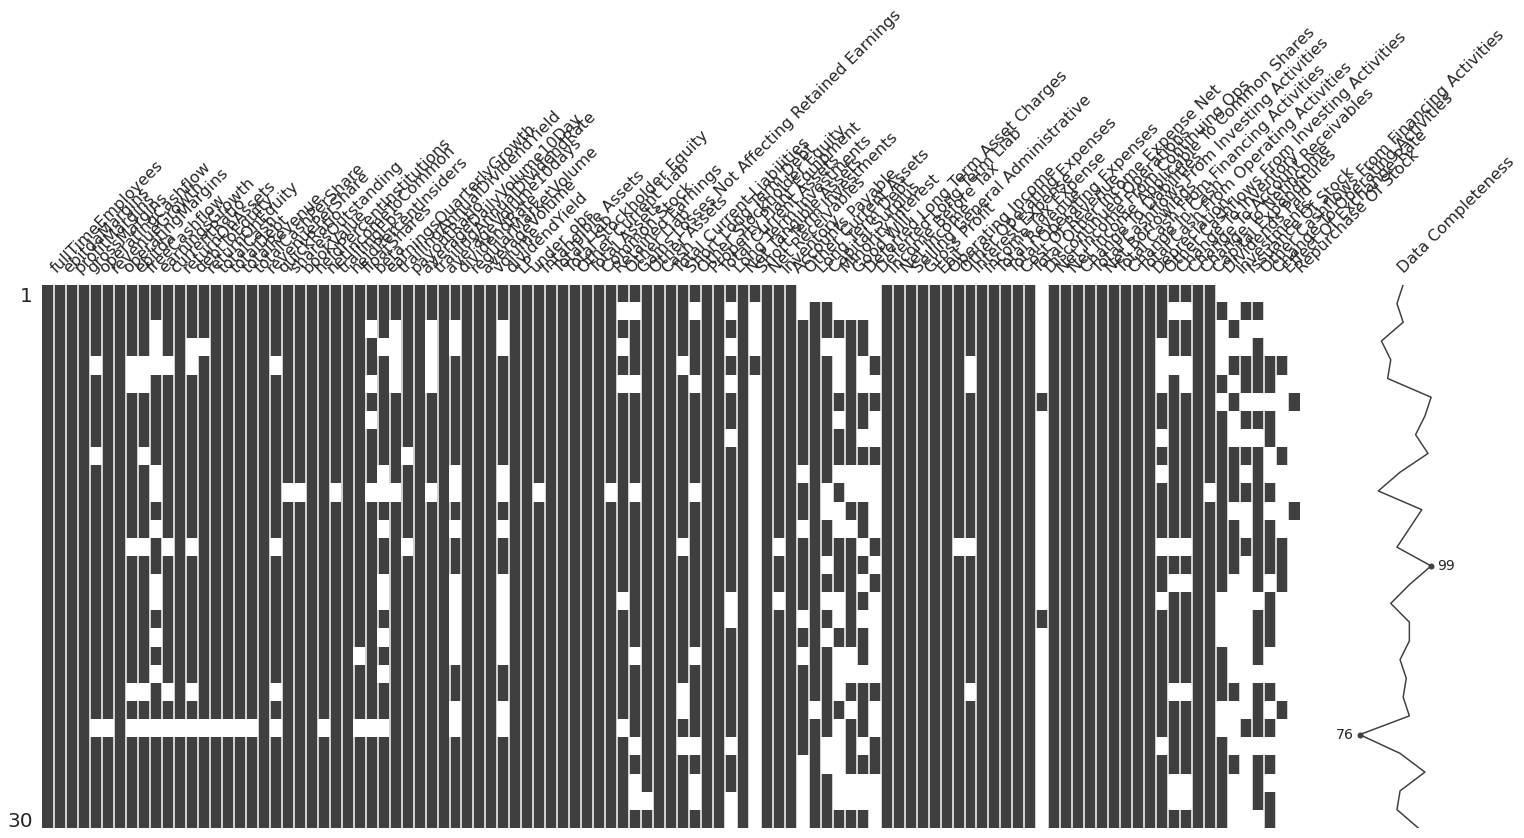

In [142]:
msno.matrix(X, labels=True)

In [143]:
# Replace NaN to 0 for all features coming from financial statements
X.iloc[:,41:] = X.fillna(0)

For other features that are not coming from the financial statements, we can use inputation methods offered by scikit-learn package. These are SimpleImputer, KNNImputer, and IterativeImputer classes 
*  SimpleImputer - utilizes multiple strategies to fill NaNs: using the mean, 
median, mode, or a constant value 
*  KNNImputer - utilizes K Nearest Neighbor modeling to estimate the missing values using the other data columns as predictors
* IterativeImputer - experimental(iterative) method which allows for any estimator to be passed into it, which it then uses to estimate missing values in a round-robin fashion

Next we will compare the different scikit-learn imputation methods as described in scikit-learn documentation [here](https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html)


In [144]:
log_close = pd.read_csv('log_close.csv')
y = log_close.iloc[0].T.loc[X.index]

At this point it is worth noting that for the task of inputting missing data, we will use Random Forest Regressor, alhough any other regressor could be used in this task as well (such as Linear Regression, Gradient Boosting Regressor, etc.).

In [160]:
from sklearn.ensemble import RandomForestRegressor
N_SPLITS = 2
regressor = RandomForestRegressor(random_state=0) # by providing an integer here, we ensure that we get the same output every time the model is run  

# To use the experimental IterativeImputer, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler



# Function to score the results on the differently imputed data
# StandardScaler is built into the function
def get_scores_for_imputer(imputer, X_missing, y_missing):
    estimator = make_pipeline(imputer, regressor)

    # To estimate the score of each method, we will use cross-validation (CV). 
    # CV is a procedure that splits the data into smaller sets, loops through each split to train and test the model on different parts of the dataset, and then evaluates the performance by averaging the values computed in the loop.
    impute_scores = cross_val_score(
        estimator, X_missing, y_missing, scoring="r2", cv=N_SPLITS)
    return impute_scores

x_labels = []

mses_fundamentals = np.zeros(4)
stds_fundamentals = np.zeros(4)

# Replace missing values by 0
def get_impute_zero_score(X_missing, y_missing):

    imputer = SimpleImputer(
        missing_values=np.nan, add_indicator=True, strategy="constant", fill_value=0)
    
    zero_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return zero_impute_scores.mean(), zero_impute_scores.std()


mses_fundamentals[0], stds_fundamentals[0] = get_impute_zero_score(X, y)

x_labels.append("Zero imputation")


# Impute missing values with mean
def get_impute_mean(X_missing, y_missing):
    imputer = SimpleImputer(missing_values=np.nan, strategy="mean", add_indicator=True)
    mean_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return mean_impute_scores.mean(), mean_impute_scores.std()


mses_fundamentals[1], stds_fundamentals[1] = get_impute_mean(X, y)

x_labels.append("Mean Imputation")


# kNN-imputation of the missing values
def get_impute_knn_score(X_missing, y_missing):
    # Define scaler to set values between 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_missing = pd.DataFrame(scaler.fit_transform(X_missing), columns=X_missing.columns)

    imputer = KNNImputer(missing_values=np.nan, add_indicator=True, n_neighbors=5)
    knn_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return knn_impute_scores.mean(), knn_impute_scores.std()


mses_fundamentals[2], stds_fundamentals[2] = get_impute_knn_score(X, y)

x_labels.append("KNN Imputation")


# Iterative imputation of the missing values
def get_impute_iterative(X_missing, y_missing):
    imputer = IterativeImputer(missing_values=np.nan,
                               add_indicator=True,
                               random_state=0,
                               n_nearest_features=3,
                               max_iter=3,
                               sample_posterior=True)
    iterative_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return iterative_impute_scores.mean(), iterative_impute_scores.std()


mses_fundamentals[3], stds_fundamentals[3] = get_impute_iterative(X, y)

x_labels.append("Iterative Imputation")

In [163]:
plt.style.use('seaborn-darkgrid')

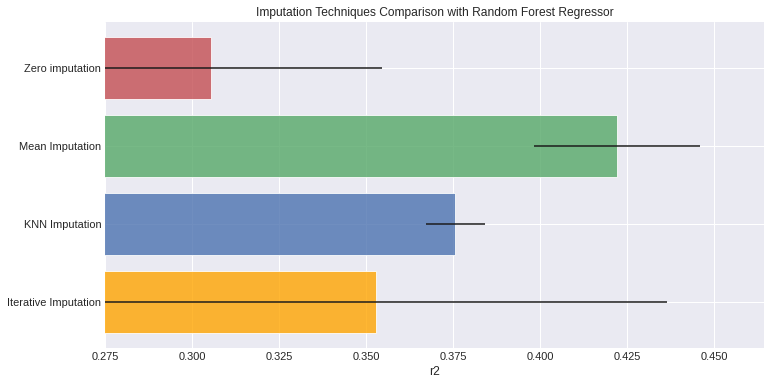

In [179]:
# Plot the results of imputation comparisons

n_bars = len(mses_fundamentals)
xval = np.arange(n_bars)

colors = ["r", "g", "b", "orange"]

#plt.figure(figsize=(26, 6))
ax1 = plt.subplot(1, 2, 1)
for j in xval:
          ax1.barh(j, 
          mses_fundamentals[j], 
          xerr=stds_fundamentals[j],
          color=colors[j],
          alpha=0.8,
          align='center')

ax1.set_title('Imputation Techniques Comparison with Random Forest Regressor')
ax1.set_xlim(left=np.min(mses_fundamentals) * 0.9, right=np.max(mses_fundamentals) * 1.1)
ax1.set_yticks(xval)
ax1.set_xlabel('r2')
ax1.invert_yaxis()
ax1.set_yticklabels(x_labels)

plt.show()

In [147]:
# Features that still have missing values
missing_knn = X.loc[:, X.isna().any()]
missing_knn.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, APG1L.VS to VLP1L.VS
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   operatingCashflow            27 non-null     float64
 1   revenueGrowth                29 non-null     float64
 2   ebitda                       25 non-null     float64
 3   freeCashflow                 24 non-null     float64
 4   earningsGrowth               19 non-null     float64
 5   currentRatio                 26 non-null     float64
 6   returnOnAssets               29 non-null     float64
 7   debtToEquity                 25 non-null     float64
 8   returnOnEquity               28 non-null     float64
 9   totalCash                    29 non-null     float64
 10  totalDebt                    29 non-null     float64
 11  totalRevenue                 29 non-null     float64
 12  totalCashPerShare            29 non-null     float64
 13  quickRatio    

In [148]:
pd.options.mode.chained_assignment = None
mean_imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
X_new = X.copy()
for i in missing_knn.columns:
  X_new[i] = mean_imputer.fit_transform(X_new[i].values.reshape(-1,1))

# We can see that the dataset no longer contains any null values
X_new.isnull().values.any()

False

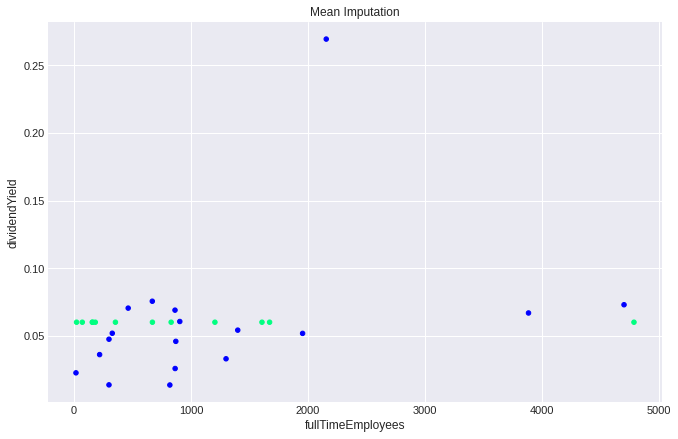

In [166]:
fig = plt.Figure()
#plt.figure(figsize=(26, 6))
null_values = X['dividendYield'].isnull()
fig = X_new.plot(x='fullTimeEmployees', y='dividendYield', kind='scatter', c=null_values, cmap='winter', title='Mean Imputation', colorbar=False)

We evaluated Linear Regression, Gradient Boosting Regressor, XGBRegressor (not shown here) and Random Forest Regressor, which proved to be the best performing regressor when measured using R2. We can see that Mean Imputation method performed the best compared to other imputation techinques, so we will use this method combination (Random Forest Regressor and Mean Imputation) to input the remaing missing values in the dataset.

R-squared tells us the proportion of the variance of the target which is explained by the model, and even though a large proportion of this variance is not being explained, a significant portion of it is, meaning there is some predictive power being provided by our features.

## Modeling the data

In [ ]:
# Let's do some grid searching to tune the hyperparameters of the model
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [ ]:
# Set up a scaler to use in the pipeline
scaler = StandardScaler()

# Adding an indicator to the imputer makes feature importance evaluation very difficult,
# but since we are not going to be worry about that for this task, we can use it
# Remember that we did not remove multicollinearity, so checking feature importances would
# be misleading anyways
imputer = IterativeImputer(random_state=0, add_indicator=True)

# Previous testing showed 'huber' was the superior loss function
regressor = GradientBoostingRegressor(loss='huber', random_state=0)

# Make the pipeline
steps = [('scaler', scaler),
         ('imputer', imputer),
         ('regressor', regressor)
        ]

estimator = Pipeline(steps=steps)

# Make the grid of hyperparameters to be tested
param_grid = {#'regressor__loss': ['ls', 'lad', 'huber'],
              'regressor__learning_rate': [.01, .1, .5],
              'regressor__n_estimators': [300, 500, 1000],
              'regressor__subsample': [0.7, 0.8, 1.0],
              'regressor__max_depth': [2, 3, 5]
             }

# Instantiate grid search and fit to data. verbose=2 will give you a report on progress,
# which is great when fitting many models. n_jobs=-1 will use all of the computer's CPU cores
grid_search = GridSearchCV(estimator, 
                           param_grid=param_grid, 
                           scoring='r2',
                           cv=5, 
                           n_jobs=-1,
                           verbose=2)
grid_fit = grid_search.fit(X, y)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [ ]:
print('Best Model: \n r-squared:', grid_fit.best_score_)
grid_fit.best_params_

Best Model: 
 r-squared: 0.23374962680489036


{'regressor__learning_rate': 0.01,
 'regressor__max_depth': 2,
 'regressor__n_estimators': 1000,
 'regressor__subsample': 0.8}

In [ ]:
grid_fit.best_score_

0.23374962680489036

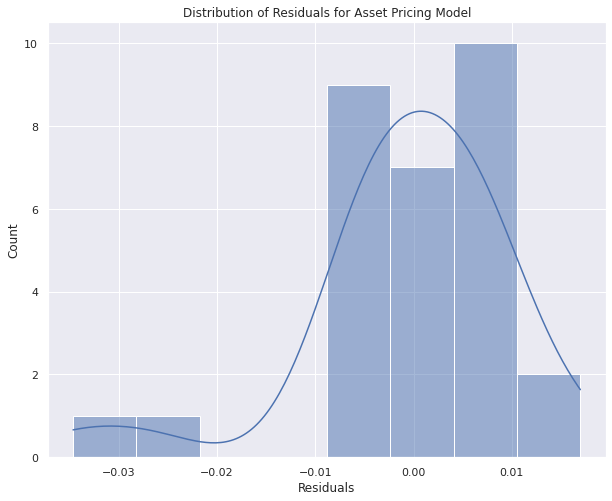

In [ ]:
# This looks good, after a long time we have our optimal parameters and a good r2 of .87
# The whole idea in generating this model was to use the residuals from it to see if they have
# a relationship with the actual returns, hopefully a nice linear relationship, let's generate
# residuals and have a look
preds = grid_fit.best_estimator_.predict(X)
resids = y - preds
plt.figure(figsize=(10, 8))
sns.histplot(resids, kde=True)
plt.title('Distribution of Residuals for Asset Pricing Model')
plt.xlabel('Residuals');

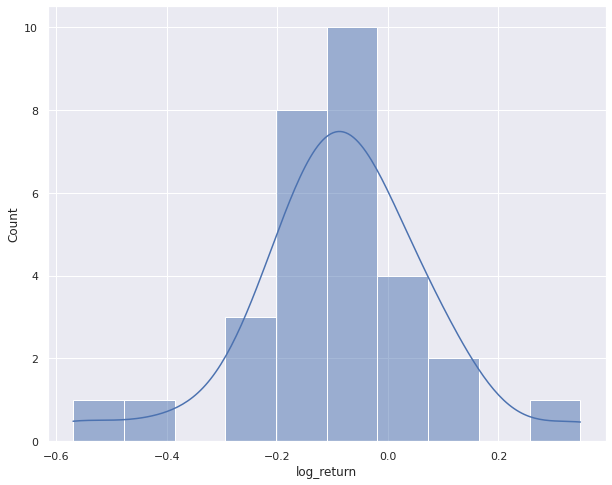

In [ ]:
log_returns = pd.read_csv('log_returns.csv')
plt.figure(figsize=(10, 8))
sns.histplot(log_returns['log_return'], kde=True);

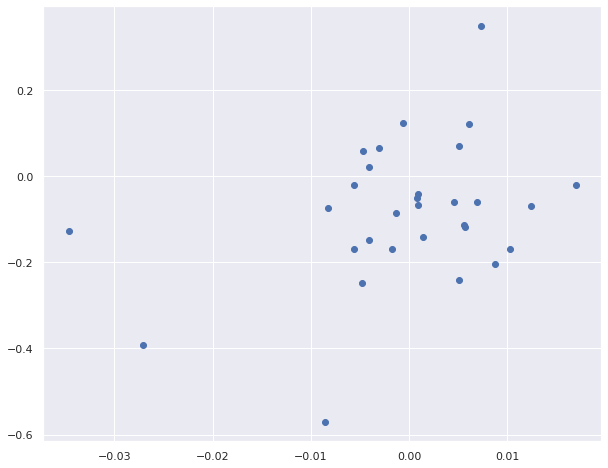

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(resids, log_returns.log_return);

In [ ]:
test_df = pd.DataFrame(zip(resids, log_returns.log_return))
test_df.columns = ['resids', 'log_returns']
test_df.head()

,resids,log_returns
0,-0.004119,0.020726
1,0.005553,-0.113182
2,0.008750,-0.204314
3,-0.027050,-0.392562
4,0.012376,-0.068295


In [ ]:
from sklearn.linear_model import LinearRegression

coefficient of determination: 0.12025784031198139


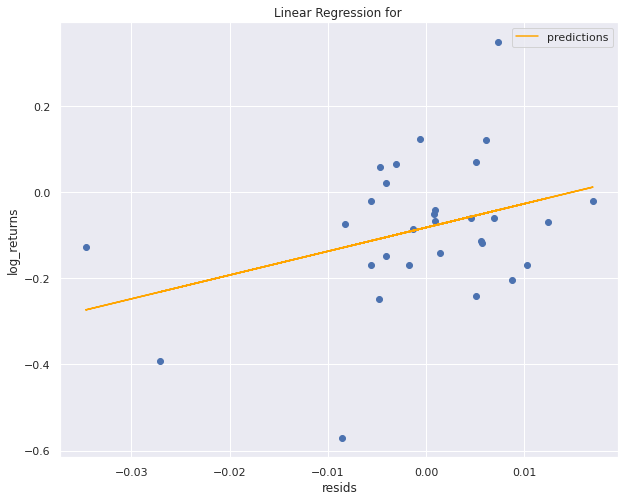

In [ ]:
model = LinearRegression()

x = np.array(test_df['resids']).reshape((-1, 1))
y = np.array(test_df['log_returns'])

model = LinearRegression().fit(x, y)

r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")

y_pred = model.predict(x)

plt.figure(figsize=(10, 8))
plt.scatter(test_df['resids'], test_df['log_returns'])
plt.xlabel('resids')
plt.ylabel('log_returns')
plt.title('Linear Regression for ')

plt.plot(test_df['resids'], y_pred, color='orange', label='predictions')
plt.legend()
plt.show()